In [179]:
pip install natsort

Note: you may need to restart the kernel to use updated packages.


In [207]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
import glob
import natsort
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.layers import Input, Conv2D, Dropout, Flatten, Activation, MaxPooling2D, Dense
from tensorflow.keras.layers import GlobalAveragePooling2D, BatchNormalization

from tensorflow.keras.models import Model,load_model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Concatenate
from sklearn.metrics import roc_auc_score

In [181]:
test_filenames = glob.glob("../input/plant-pathology-2020-fgvc7/images/Test*.jpg")
train_filenames = glob.glob("../input/plant-pathology-2020-fgvc7/images/Train*.jpg")

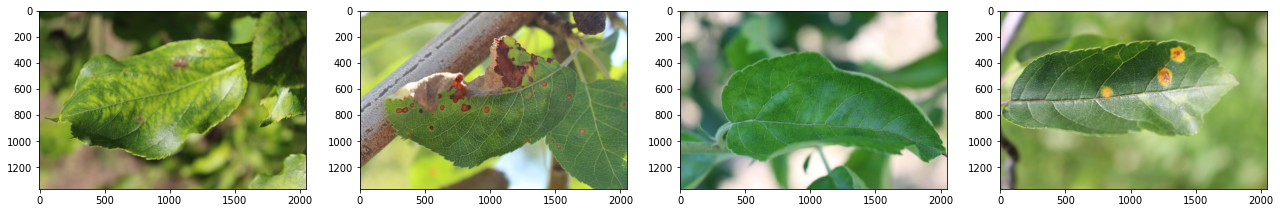

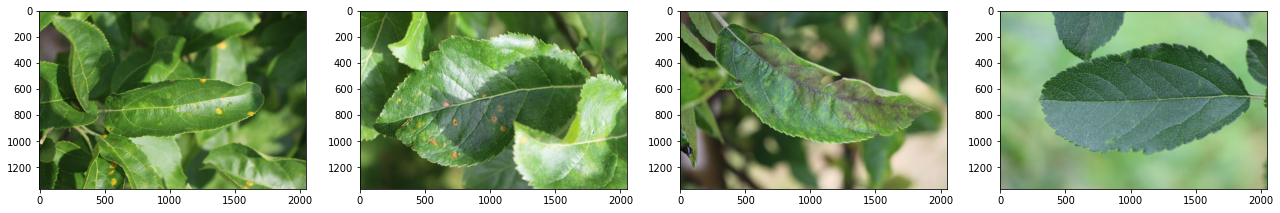

In [182]:
figure, axes = plt.subplots(figsize=(22, 6), nrows=1, ncols=4)
train_images = train_fillenames[:4]
for i in range(4):
    image = cv2.cvtColor(cv2.imread(train_images[i]), cv2.COLOR_BGR2RGB)
    axes[i].imshow(image)
    
figure, axes = plt.subplots(figsize=(22, 6), nrows=1, ncols=4)
test_images = test_fillenames[:4]
for i in range(4):
    image = cv2.cvtColor(cv2.imread(test_images[i]), cv2.COLOR_BGR2RGB)
    axes[i].imshow(image)

In [183]:
train_filenames=natsort.natsorted(train_filenames)

In [184]:
train_labels=pd.read_csv("../input/plant-pathology-2020-fgvc7/train.csv")
train_labels

,image_id,healthy,multiple_diseases,rust,scab
0,Train_0,0,0,0,1
1,Train_1,0,1,0,0
2,Train_2,1,0,0,0
3,Train_3,0,0,1,0
4,Train_4,1,0,0,0
...,...,...,...,...,...
1816,Train_1816,0,0,0,1
1817,Train_1817,1,0,0,0
1818,Train_1818,1,0,0,0
1819,Train_1819,0,0,1,0


In [185]:
train_labels.loc[1173] = train_labels.loc[379]
train_labels.loc[1] = train_labels.loc[171]

In [186]:
train_labels["image_id"].loc[1173] = "Train_1173"
train_labels["image_id"].loc[1] = "Train_1"

/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [187]:
train_labels["path"]=train_filenames

In [188]:
train_labels

,image_id,healthy,multiple_diseases,rust,scab,path
0,Train_0,0,0,0,1,../input/plant-pathology-2020-fgvc7/images/Tra...
1,Train_1,0,0,1,0,../input/plant-pathology-2020-fgvc7/images/Tra...
2,Train_2,1,0,0,0,../input/plant-pathology-2020-fgvc7/images/Tra...
3,Train_3,0,0,1,0,../input/plant-pathology-2020-fgvc7/images/Tra...
4,Train_4,1,0,0,0,../input/plant-pathology-2020-fgvc7/images/Tra...
...,...,...,...,...,...,...
1816,Train_1816,0,0,0,1,../input/plant-pathology-2020-fgvc7/images/Tra...
1817,Train_1817,1,0,0,0,../input/plant-pathology-2020-fgvc7/images/Tra...
1818,Train_1818,1,0,0,0,../input/plant-pathology-2020-fgvc7/images/Tra...
1819,Train_1819,0,0,1,0,../input/plant-pathology-2020-fgvc7/images/Tra...


In [189]:
test_labels = pd.read_csv("../input/plant-pathology-2020-fgvc7/test.csv")
test_labels

,image_id
0,Test_0
1,Test_1
2,Test_2
3,Test_3
4,Test_4
...,...
1816,Test_1816
1817,Test_1817
1818,Test_1818
1819,Test_1819


In [190]:
test_filenames = natsort.natsorted(test_filenames)

In [191]:
test_labels["path"] = test_filenames

In [192]:
test_labels

,image_id,path
0,Test_0,../input/plant-pathology-2020-fgvc7/images/Tes...
1,Test_1,../input/plant-pathology-2020-fgvc7/images/Tes...
2,Test_2,../input/plant-pathology-2020-fgvc7/images/Tes...
3,Test_3,../input/plant-pathology-2020-fgvc7/images/Tes...
4,Test_4,../input/plant-pathology-2020-fgvc7/images/Tes...
...,...,...
1816,Test_1816,../input/plant-pathology-2020-fgvc7/images/Tes...
1817,Test_1817,../input/plant-pathology-2020-fgvc7/images/Tes...
1818,Test_1818,../input/plant-pathology-2020-fgvc7/images/Tes...
1819,Test_1819,../input/plant-pathology-2020-fgvc7/images/Tes...


In [193]:
# train_labels["healthy"] = train_labels["healthy"].astype('string')

In [194]:
IMAGE_SIZE = 299
BATCH_SIZE = 32

In [195]:
train_df, valid_df = train_test_split(train_labels, test_size=0.2)


In [196]:
train_generator = ImageDataGenerator(horizontal_flip = True, vertical_flip=True, width_shift_range=0.1, height_shift_range=0.1, rotation_range=360, zoom_range=0.3, rescale=1/255.0)
train_generator_iterator = train_generator.flow_from_dataframe(dataframe=train_df,
                                                               x_col = "path", 
                                                               y_col = ["healthy", "multiple_diseases", "rust", "scab"],
                                                               target_size=(IMAGE_SIZE, IMAGE_SIZE), batch_size=BATCH_SIZE, 
                                                               class_mode="raw")


Found 1456 validated image filenames.


In [197]:
valid_generator = ImageDataGenerator(rescale=1/255.0 )
valid_generator_iterator = valid_generator.flow_from_dataframe(dataframe=valid_df,
                                                               x_col = "path",
                                                               y_col = ["healthy", "multiple_diseases", "rust", "scab"],
                                                               target_size=(IMAGE_SIZE, IMAGE_SIZE), batch_size=BATCH_SIZE, 
                                                               class_mode="raw")

Found 365 validated image filenames.


In [198]:
test_generator = ImageDataGenerator(rescale=1/255.0 )
test_generator_iterator = test_generator.flow_from_dataframe(dataframe=test_labels, 
                                                             shuffle=False,
                                                               x_col = "path",
                                                               target_size=(IMAGE_SIZE, IMAGE_SIZE), batch_size=BATCH_SIZE, class_mode = None)

Found 1821 validated image filenames.


In [199]:
input_tensor = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))

In [200]:
xp = tf.keras.applications.Xception(
    include_top=False,
    weights="imagenet",
    input_tensor=input_tensor,
    input_shape=(299, 299, 3),
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
)

x = GlobalAveragePooling2D()(xp.output)
x = Dense(50, activation='relu', name='fc1')(x)
output = Dense(4, activation="softmax")(x)

model = Model(inputs=input_tensor, outputs=output)

In [201]:
checkpoint_cb = ModelCheckpoint("my_keras_model.h5", save_best_only=True, verbose=1)
early_stopping_cb = EarlyStopping(patience=12, restore_best_weights=True)
reducelr_cb = ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=5, mode="min", verbose=1)

In [202]:
model.compile(optimizer="sgd", loss="categorical_crossentropy", metrics=[tf.keras.metrics.AUC()])
history = model.fit(train_generator_iterator, epochs=64, validation_data=valid_generator_iterator,
                   callbacks=[checkpoint_cb, early_stopping_cb, reducelr_cb])

Epoch 1/64
46/46 [==============================] - 105s 2s/step - loss: 1.2526 - auc_1: 0.7117 - val_loss: 1.1293 - val_auc_1: 0.7702

Epoch 00001: val_loss improved from inf to 1.12927, saving model to my_keras_model.h5
Epoch 2/64
46/46 [==============================] - 99s 2s/step - loss: 0.9275 - auc_1: 0.8970 - val_loss: 0.7221 - val_auc_1: 0.9413

Epoch 00002: val_loss improved from 1.12927 to 0.72210, saving model to my_keras_model.h5
Epoch 3/64
46/46 [==============================] - 98s 2s/step - loss: 0.6405 - auc_1: 0.9430 - val_loss: 0.4729 - val_auc_1: 0.9685

Epoch 00003: val_loss improved from 0.72210 to 0.47289, saving model to my_keras_model.h5
Epoch 4/64
46/46 [==============================] - 98s 2s/step - loss: 0.4834 - auc_1: 0.9617 - val_loss: 0.3824 - val_auc_1: 0.9771

Epoch 00004: val_loss improved from 0.47289 to 0.38238, saving model to my_keras_model.h5
Epoch 5/64
46/46 [==============================] - 99s 2s/step - loss: 0.3890 - auc_1: 0.9746 - val_lo

In [208]:
model = load_model("my_keras_model.h5")
pred = model.predict(test_generator_iterator)

In [211]:
submission = pd.read_csv("../input/plant-pathology-2020-fgvc7/sample_submission.csv")
submission.loc[:, "healthy":] = pred 
submission.to_csv("submission_xp.csv", index=False)